In [129]:
import numpy as np
import scipy as sp
from scipy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt

In [130]:
# Setting up the dataframe

file = 'SouthCalifornia-1982-2011_Physics-of-Data.dat'
data = np.genfromtxt(file,
                     dtype=None,
                     delimiter=' ')
df = pd.DataFrame(data)
df.columns = ['event', 'prev_event', 'time', 'magnitude', 'x', 'y', 'z']

In [131]:
# Possible functions to fit the data
def loglogt(t, A, B):
    return A + B*t

def logPmod(t, A, B, C):
    return A + B/t**C

def logt(t, p, q, r):
    return p*np.log(t*r) + q

In [132]:
def select_bin_number(x, min_nbin = 7, fraction = 0.001):
    n_min = fraction*len(x)
    
    n, bin_extremes, _ = plt.hist(x, bins = min_nbin )
    plt.close()
    last_n = n[-1]
    
    if last_n > n_min:
        return min_nbin, bin_extremes
    else:
        i = min_nbin 
        nbin = min_nbin
        while last_n < n_min and nbin < 100:
            nbin = nbin + 1
            #print('Attempt with nbin = {} \n'.format(nbin))
            n, _, _ = plt.hist(x, bins = nbin )
            plt.close()
            #print(n[i-1:])
            last_n = n[i-1:].sum()
            #print('Last n: ', last_n)
            #print('All n : ', n.sum())
            
        n, bin_extremes, _ = plt.hist(x, bins = nbin )
        plt.close()
        bins = np.concatenate((bin_extremes[:min_nbin],bin_extremes[-1:]))
        return nbin, bins

In [133]:
# Function to plot waiting times with R condition (fixed m_min)

from scipy import optimize
from scipy.stats import chisquare

def plot_Pm_t_Rcondition(m, R_fractions, df, sigma_filter = 10):
    #print('m = ', m, '\n')
    
    # distance and waiting times between events of magnitude > m
    dfm = df[df['magnitude'] > m]
    dfm = dfm.set_index(np.arange(len(dfm)))
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    #vector for fit parameters for each R_max fraction
    As = []
    Bs = []
    Cs = []
    chis = []
    ps = []
    
    #Repeat plots and fits for each R_max fraction
    for i in range(1, R_fractions+1):
        
        """
        # searching for the next event within r_lim to compute waiting time
        time_diff = []
        for j in range(1, len(X)):
            single_r = np.linalg.norm(X[j]-X[j-1])
            k=1
            while single_r > 1.0*i/R_fractions*r.max():
                single_r = np.linalg.norm(X[j+k]-X[j-1])
                k = k+1
                if (j+k)==len(r):
                    break
            if (j+k)==len(r):
                break
            else:
                time_diff.append((timem[j+k-1] - timem[j-1])/time_d.max())
        print("Sono stati rimossi {} eventi ({}%)\n"\
              .format(len(time_d)-len(time_diff), round(100*(1-(len(time_diff)/len(time_d))))))
        """

        # building the mask to filter "distances < R" and apply that to original waiting times
        print("R_max = "+str(i)+"/"+str(R_fractions)+" * max_distance")
        R_mask = pd.Series(np.concatenate((np.array([True]), r <= i/R_fractions*r.max())))
        dfmr = dfm[R_mask]
        r_norm = r[R_mask[1:]]/r.max()  
        time_diff = time_d[R_mask[1:]]/time_d.max()
        print("Sono stati rimossi {} eventi ({}%)\n"\
              .format(len(dfm)-len(dfmr), round(100*(1-(len(dfmr)/len(dfm))))))
        
        """
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
        ax1.plot(time_d)
        #ax1.axhline(time_d.mean()*2 + sigma_filter*time_d.std(), c = 'r')
        prova = time_d[time_d != time_d.max()]
        maximum = prova.max()
        if time_d.max()*3/4 > maximum:
            time_d = prova
        #time_d = time_d[mask]
        #print('Eliminated samples : ', len(timem) - len(time_d) -1, '\n')
        ax2.plot(time_d)

        plt.show()
        plt.close()
        """
        

        # computing suitable sizes of bins
        bin_number, bins = select_bin_number(time_diff)

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

        n, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')

        bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
        sigma_n = np.sqrt(n)
        ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.', label = 'entries with \npoisson error')
        ax1.legend(loc = 'upper right')
        ax1.set_yscale('log')

        print('Occurrencies for the first bin with {} original bins: '.format(bin_number), n[0], '\n')

        # rescaling the tail entries with the number of bins merged into the tail
        n = np.concatenate((n[:-1], n[-1:]/(bin_number+1-7)))
        # linear fit over the log of the entries
        #params1, _ = optimize.curve_fit(logP, bin_centers, np.log(n), p0 = [np.log(n[0]),-1])
        params1, _ = optimize.curve_fit(loglogt, bin_centers, np.log(n), p0 = [-1,5])
        [A,B] = params1
        print('A = {}\nB = {}\n'.format(round(A,2), round(B,2)))

        # chi squared and p-value tests
        chisq, p = chisquare(np.log(n), loglogt(bin_centers, *params1), ddof = 2 )

        ax2.plot(bin_centers, np.log(n), 'r.', label = 'entries')
        ax2.plot(bin_centers, loglogt(bin_centers, *params1), 
                 label = 'A = {} \nB = {}\n$\chi^2$ = {} \np-value = {}'\
                 .format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(p,2)))
        ax2.legend()

        plt.show()
        plt.close()

        gridsize = (2, 3)
        fig = plt.figure(figsize=(10, 4))
        ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
        ax1.plot(time_diff)

        ax2 = plt.subplot2grid(gridsize, (0, 2), colspan = 1, rowspan = 2)
        n2, bins2, patches2 = ax2.hist(time_diff, bins = bins, orientation = 'horizontal', color = 'skyblue')
        #hist_with_kde(ax2, time_diff, bins = bins, histtype = 'step', orientation = 'horizontal')
        ax2.set_xscale('log')
        ax2.axis('off')
        plt.show()
        plt.close()

        # parameters of Pm from the one of logPm 
        #a = np.exp(A)
        #b = -B/time_d.max()
        
        #Add parameters in their lists
        As.append(A)
        Bs.append(B)
        #Cs.append(C)
        chis.append(chisq)
        ps.append(p)
        
    return As, Bs, chis, ps

R_max = 1/10 * max_distance
Sono stati rimossi 5126 eventi (45%)

Occurrencies for the first bin with 9 original bins:  5856.0 

A = 7.76
B = -14.74



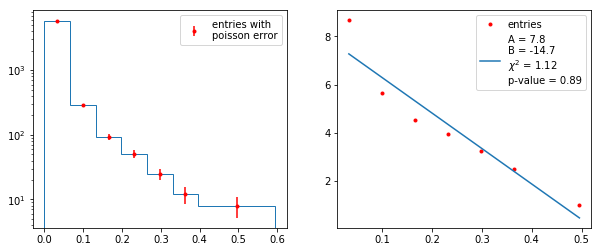

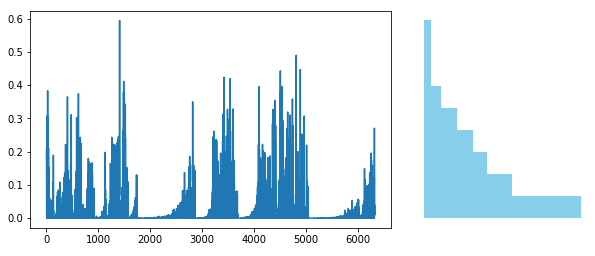

R_max = 2/10 * max_distance
Sono stati rimossi 3696 eventi (32%)

Occurrencies for the first bin with 11 original bins:  7024.0 

A = 8.02
B = -12.04



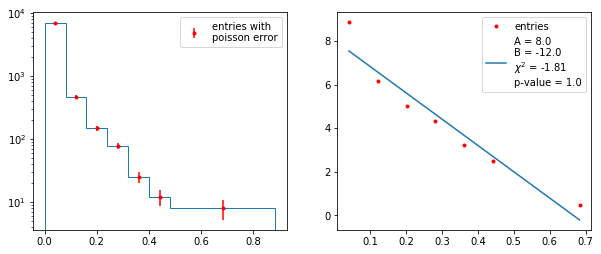

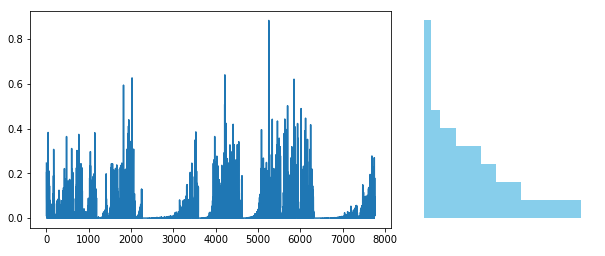

R_max = 3/10 * max_distance
Sono stati rimossi 2517 eventi (22%)

Occurrencies for the first bin with 11 original bins:  7842.0 

A = 8.27
B = -11.4



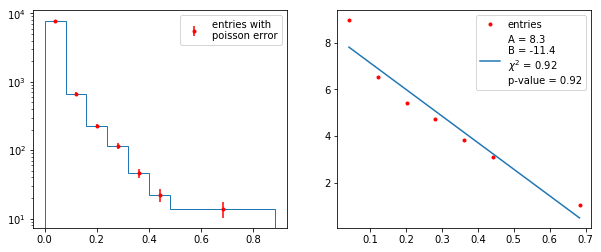

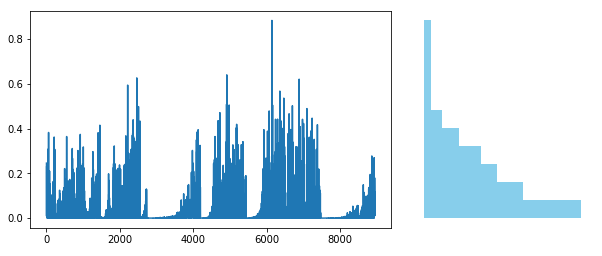

R_max = 4/10 * max_distance
Sono stati rimossi 1652 eventi (14%)

Occurrencies for the first bin with 10 original bins:  8558.0 

A = 8.57
B = -11.34



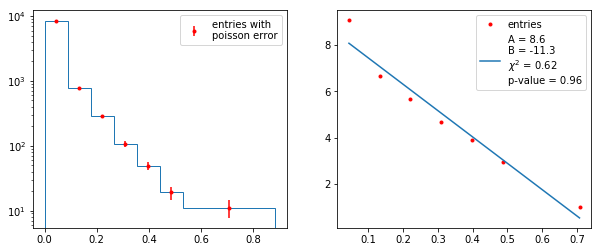

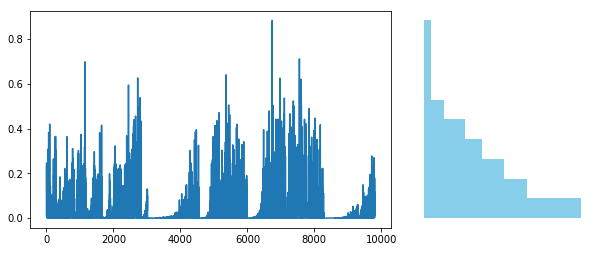

R_max = 5/10 * max_distance
Sono stati rimossi 943 eventi (8%)

Occurrencies for the first bin with 10 original bins:  9220.0 

A = 8.6
B = -10.27



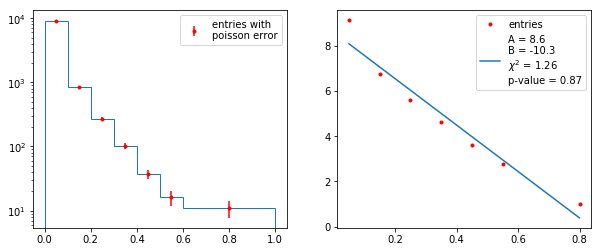

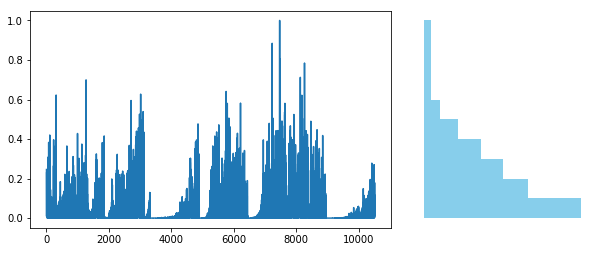

R_max = 6/10 * max_distance
Sono stati rimossi 463 eventi (4%)

Occurrencies for the first bin with 10 original bins:  9564.0 

A = 8.68
B = -10.18



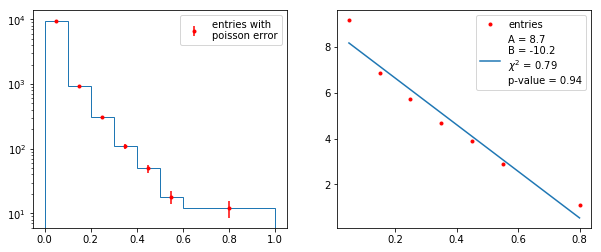

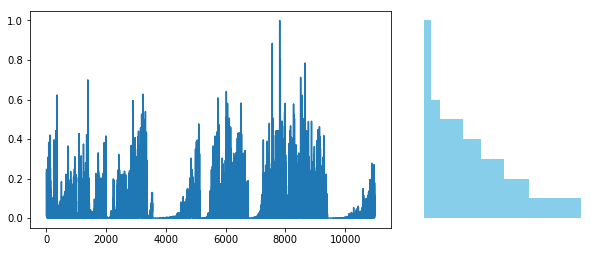

R_max = 7/10 * max_distance
Sono stati rimossi 117 eventi (1%)

Occurrencies for the first bin with 10 original bins:  9824.0 

A = 8.74
B = -10.22



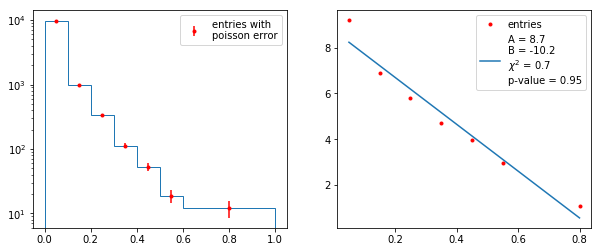

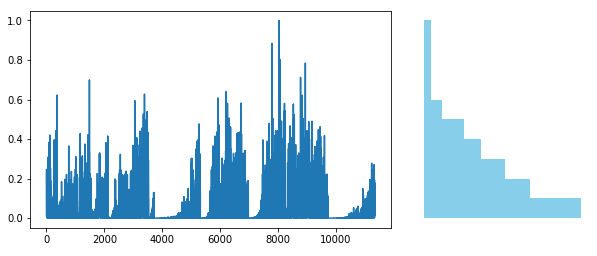

R_max = 8/10 * max_distance
Sono stati rimossi 18 eventi (0%)

Occurrencies for the first bin with 10 original bins:  9894.0 

A = 8.76
B = -10.25



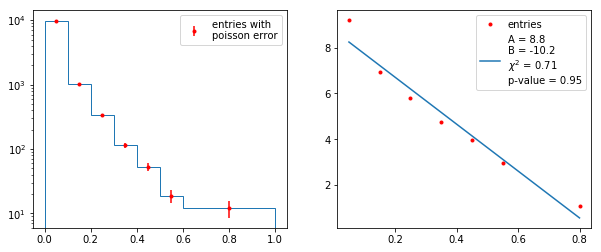

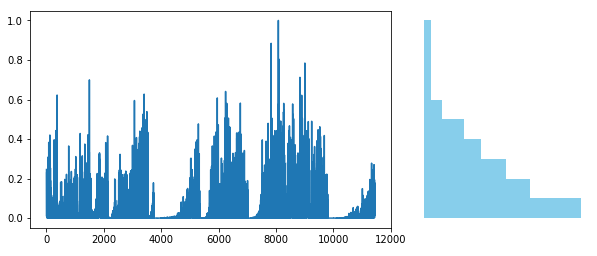

R_max = 9/10 * max_distance
Sono stati rimossi 5 eventi (0%)

Occurrencies for the first bin with 10 original bins:  9904.0 

A = 8.76
B = -10.25



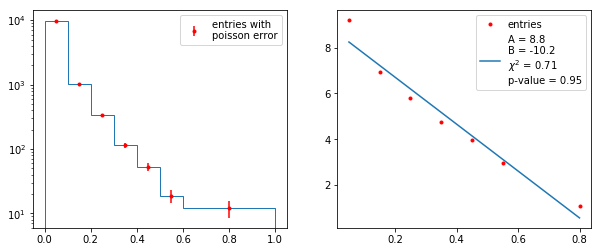

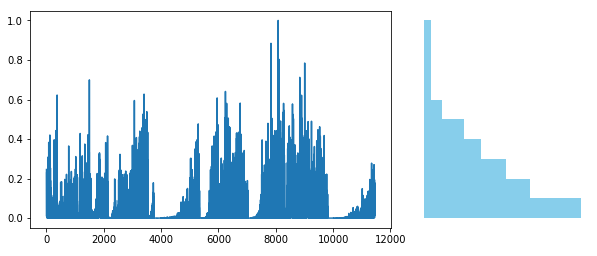

R_max = 10/10 * max_distance
Sono stati rimossi 0 eventi (0%)

Occurrencies for the first bin with 10 original bins:  9908.0 

A = 8.76
B = -10.25



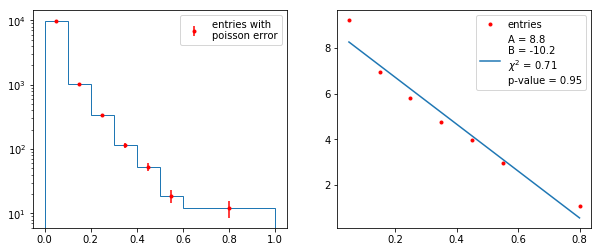

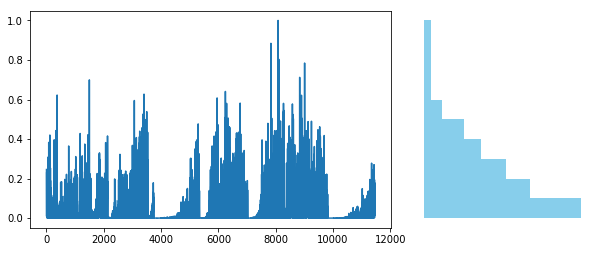

In [134]:
# Rifare plot cambiando funzione da fittare (non retta)
As, Bs, chis, ps = plot_Pm_t_Rcondition(3,10,df)

p = 1.84
q = -14.13
t = 11.46



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


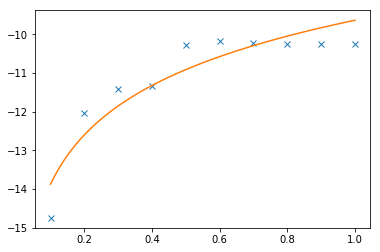

In [146]:
# Plot di B in funzione del raggio limite (waiting times minori per R bassi perchè decresce di più)
plt.plot(np.linspace(0.1,1,10), Bs, 'x') # R_lim dato come frazione di R_max
params_Bs, _ = optimize.curve_fit(logt, np.linspace(0.1,1,10), Bs)
print('p = {}\nq = {}\nt = {}\n'.format(round(params_Bs[0],2), round(params_Bs[1],2), round(params_Bs[2],2)))
plt.plot(np.linspace(0.1,1,100), logt(np.linspace(0.1,1,100), *params_Bs))
plt.show()

p = 0.47
q = 8.16
t = 4.46



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


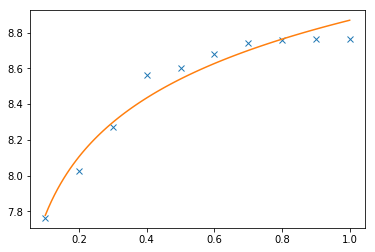

In [147]:
# Plot di A in funzione del raggio massimo
plt.plot(np.linspace(0.1,1,10), As, 'x')
params_As, _ = optimize.curve_fit(logt, np.linspace(0.1,1,10), As)
print('p = {}\nq = {}\nt = {}\n'.format(round(params_As[0],2), round(params_As[1],2), round(params_As[2],2)))
plt.plot(np.linspace(0.1,1,100), logt(np.linspace(0.1,1,100), *params_As))
plt.show()

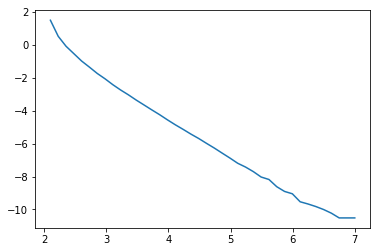

In [16]:
def func(x, df):
    return (len(df[df['magnitude'] > x])/len(df[df['magnitude'] < x]))

# plot of f(m) = log( n[m,7] / n[2,m] )
x = np.linspace(2.1,7,40)
y = []
for i in x:
    y.append(func(i,df))
plt.plot(x,np.log(y))
plt.show()